In [1]:
# ÂØºÂÖ•ÂøÖË¶ÅÁöÑÂ∫ì
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import StringType, DoubleType
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from wordcloud import WordCloud
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# ËÆæÁΩÆÂõæË°®Ê†∑Âºè
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("Â∫ìÂØºÂÖ•ÂÆåÊàêÔºÅ")


Â∫ìÂØºÂÖ•ÂÆåÊàêÔºÅ


In [2]:
# ÂàùÂßãÂåñ Spark Session Âπ∂Âä†ËΩΩÊ∏ÖÊ¥óÂêéÁöÑÊï∞ÊçÆ
spark = SparkSession.builder \
    .appName("TweetAnalysis_EDA_Sentiment") \
    .master("local[*]") \
    .config("spark.driver.memory", "16g") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

print(f"Spark Version: {spark.version}")

# Âä†ËΩΩÊ∏ÖÊ¥óÂêéÁöÑÊï∞ÊçÆÔºàÂü∫‰∫éÁ¨¨‰∫åÊ≠•ÁöÑËæìÂá∫Ë∑ØÂæÑÔºâ
cleaned_data_path = "/home/jovyan/work/data/processed/cleaned_comments.parquet"
print(f"Â∞ùËØïÂä†ËΩΩÊï∞ÊçÆ‰ªé: {cleaned_data_path}")

try:
    df_cleaned = spark.read.parquet(cleaned_data_path)
    df_cleaned.cache()
    record_count = df_cleaned.count()
    print(f"‚úÖ Ê∏ÖÊ¥óÂêéÊï∞ÊçÆÂä†ËΩΩÂÆåÊàêÔºåÂÖ± {record_count:,} Êù°ËÆ∞ÂΩï")
    print("\nÊï∞ÊçÆÁªìÊûÑ:")
    df_cleaned.printSchema()
    
    # ÊòæÁ§∫ÂâçÂá†Ë°åÊï∞ÊçÆÈ¢ÑËßà
    print("\nÊï∞ÊçÆÈ¢ÑËßàÔºàÂâç3Ë°åÔºâ:")
    df_cleaned.select("id", "`subreddit.name`", "cleaned_body", "sentiment").show(3, truncate=False)
    
except Exception as e:
    print(f"‚ùå Êï∞ÊçÆÂä†ËΩΩÂ§±Ë¥•: {e}")
    print("ËØ∑Á°Æ‰øùÂ∑≤ÁªèËøêË°åÂÆåÁ¨¨‰∫åÊ≠•Êï∞ÊçÆÊ∏ÖÊ¥ónotebook")
    # ÂàõÂª∫‰∏Ä‰∏™Á©∫ÁöÑDataFrame‰Ωú‰∏∫fallback
    df_cleaned = None


Spark Version: 3.5.0
Â∞ùËØïÂä†ËΩΩÊï∞ÊçÆ‰ªé: /home/jovyan/work/data/processed/cleaned_comments.parquet
‚úÖ Ê∏ÖÊ¥óÂêéÊï∞ÊçÆÂä†ËΩΩÂÆåÊàêÔºåÂÖ± 459,171 Êù°ËÆ∞ÂΩï

Êï∞ÊçÆÁªìÊûÑ:
root
 |-- id: string (nullable = true)
 |-- subreddit.name: string (nullable = true)
 |-- created_utc: long (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- body: string (nullable = true)
 |-- cleaned_body: string (nullable = true)
 |-- tokens_cleaned: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- sentiment: double (nullable = true)
 |-- score: long (nullable = true)


Êï∞ÊçÆÈ¢ÑËßàÔºàÂâç3Ë°åÔºâ:
+-------+--------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [3]:
# Âü∫Á°ÄÊï∞ÊçÆÊ¶ÇËßàÂíåÁªüËÆ°
print("=== Âü∫Á°ÄÊï∞ÊçÆÊ¶ÇËßà ===")

# È™åËØÅÊï∞ÊçÆÊòØÂê¶ÊàêÂäüÂä†ËΩΩ
if df_cleaned is None:
    print("‚ùå Êï∞ÊçÆÊú™Âä†ËΩΩÔºåËØ∑ÂÖàËøêË°å‰∏ä‰∏Ä‰∏™cellÂπ∂Á°Æ‰øùÊï∞ÊçÆÂä†ËΩΩÊàêÂäü")
else:
    # 1. Êï∞ÊçÆÂü∫Êú¨‰ø°ÊÅØ
    print("1. Êï∞ÊçÆÂü∫Êú¨‰ø°ÊÅØ:")
    print(f"ÊÄªËÆ∞ÂΩïÊï∞: {df_cleaned.count():,}")
    print(f"ÊÄªÂàóÊï∞: {len(df_cleaned.columns)}")

    # 2. ÂêÑÂàóÊï∞ÊçÆÂÆåÊï¥ÊÄßÊ£ÄÊü•
    print("\n2. Êï∞ÊçÆÂÆåÊï¥ÊÄß:")
    for col_name in df_cleaned.columns:
        # Â§ÑÁêÜÂåÖÂê´ÁÇπÂè∑ÁöÑÂàóÂêç
        if "." in col_name:
            null_count = df_cleaned.filter(F.col(f"`{col_name}`").isNull()).count()
        else:
            null_count = df_cleaned.filter(F.col(col_name).isNull()).count()
        total_count = df_cleaned.count()
        print(f"  {col_name}: {((total_count - null_count) / total_count * 100):.1f}% ÂÆåÊï¥")

    # 3. ÊÉÖÊÑüÂàÜÊï∞ÁªüËÆ°
    print("\n3. ÊÉÖÊÑüÂàÜÊï∞ÂàÜÂ∏É:")
    sentiment_stats = df_cleaned.select("sentiment").describe()
    sentiment_stats.show()

    # 4. Â≠êÁâàÂùóÂàÜÂ∏É
    print("4. Â≠êÁâàÂùóÂàÜÂ∏É (Top 10):")
    subreddit_dist = df_cleaned.groupBy("`subreddit.name`").count().orderBy(F.desc("count")).limit(10)
    subreddit_dist.show(truncate=False)


=== Âü∫Á°ÄÊï∞ÊçÆÊ¶ÇËßà ===
1. Êï∞ÊçÆÂü∫Êú¨‰ø°ÊÅØ:
ÊÄªËÆ∞ÂΩïÊï∞: 459,171
ÊÄªÂàóÊï∞: 9

2. Êï∞ÊçÆÂÆåÊï¥ÊÄß:
  id: 100.0% ÂÆåÊï¥
  subreddit.name: 100.0% ÂÆåÊï¥
  created_utc: 100.0% ÂÆåÊï¥
  timestamp: 100.0% ÂÆåÊï¥
  body: 100.0% ÂÆåÊï¥
  cleaned_body: 100.0% ÂÆåÊï¥
  tokens_cleaned: 100.0% ÂÆåÊï¥
  sentiment: 98.9% ÂÆåÊï¥
  score: 100.0% ÂÆåÊï¥

3. ÊÉÖÊÑüÂàÜÊï∞ÂàÜÂ∏É:
+-------+--------------------+
|summary|           sentiment|
+-------+--------------------+
|  count|              454264|
|   mean|-0.00644086346265...|
| stddev|  0.6588389261269937|
|    min|             -0.9999|
|    max|              0.9999|
+-------+--------------------+

4. Â≠êÁâàÂùóÂàÜÂ∏É (Top 10):
+--------------+-----+
|subreddit.name|count|
+--------------+-----+
|politics      |36989|
|worldnews     |35283|
|askreddit     |25863|
|news          |9524 |
|collapse      |9490 |
|futurology    |8904 |
|science       |7063 |
|environment   |6819 |
|canada        |6722 |
|australia     |5993 |
+--------------+-----

In [4]:
# ‰ΩøÁî®VADERËøõË°åÈáçÊñ∞ÊÉÖÊÑüÂàÜÊûêÔºàÊîπËøõÂéüÊúâÊÉÖÊÑüÂàÜÊï∞Ôºâ
print("=== VADERÊÉÖÊÑüÂàÜÊûê ===")

# È™åËØÅÊï∞ÊçÆÊòØÂê¶ÂèØÁî®
if df_cleaned is None:
    print("‚ùå Êï∞ÊçÆÊú™Âä†ËΩΩÔºåËØ∑ÂÖàËøêË°åÂâçÈù¢ÁöÑcellsÂπ∂Á°Æ‰øùÊï∞ÊçÆÂä†ËΩΩÊàêÂäü")
else:
    # ÂàõÂª∫VADERÊÉÖÊÑüÂàÜÊûêÂô®
    analyzer = SentimentIntensityAnalyzer()

    def analyze_sentiment_vader(text):
        """‰ΩøÁî®VADERËøõË°åÊÉÖÊÑüÂàÜÊûê"""
        if text is None:
            return None
        scores = analyzer.polarity_scores(str(text))
        return scores['compound']  # ËøîÂõûÂ§çÂêàÊÉÖÊÑüÂàÜÊï∞ (-1 Âà∞ 1)

    # ÂàõÂª∫UDFÁî®‰∫éSpark
    sentiment_udf = F.udf(analyze_sentiment_vader, DoubleType())

    # Â∫îÁî®VADERÊÉÖÊÑüÂàÜÊûêÂà∞Ê∏ÖÊ¥óÂêéÁöÑÊñáÊú¨
    print("Ê≠£Âú®Â∫îÁî®VADERÊÉÖÊÑüÂàÜÊûê...")
    df_with_vader = df_cleaned.withColumn("vader_sentiment", sentiment_udf(F.col("cleaned_body")))

    # ÁºìÂ≠òÁªìÊûú
    df_with_vader.cache()

    print("VADERÊÉÖÊÑüÂàÜÊûêÂÆåÊàêÔºÅ")

    # ÊØîËæÉÂéüÂßãÊÉÖÊÑüÂàÜÊï∞ÂíåVADERÂàÜÊï∞
    print("\nÂéüÂßãÊÉÖÊÑüÂàÜÊï∞ vs VADERÂàÜÊï∞ÂØπÊØî:")
    comparison = df_with_vader.select("sentiment", "vader_sentiment").filter(
        F.col("sentiment").isNotNull() & F.col("vader_sentiment").isNotNull()
    ).limit(10)
    comparison.show()

    # VADERÊÉÖÊÑüÂàÜÊï∞ÁªüËÆ°
    print("\nVADERÊÉÖÊÑüÂàÜÊï∞ÁªüËÆ°:")
    vader_stats = df_with_vader.select("vader_sentiment").describe()
    vader_stats.show()


=== VADERÊÉÖÊÑüÂàÜÊûê ===
Ê≠£Âú®Â∫îÁî®VADERÊÉÖÊÑüÂàÜÊûê...
VADERÊÉÖÊÑüÂàÜÊûêÂÆåÊàêÔºÅ

ÂéüÂßãÊÉÖÊÑüÂàÜÊï∞ vs VADERÂàÜÊï∞ÂØπÊØî:
+---------+---------------+
|sentiment|vader_sentiment|
+---------+---------------+
|   0.5106|         0.5106|
|      0.0|            0.0|
|   0.7269|         0.7269|
|   0.6021|         0.6021|
|  -0.9824|         -0.992|
|   0.8948|         0.8948|
|  -0.8556|        -0.6997|
|    -0.25|          -0.25|
|    0.398|         0.7949|
|  -0.9118|        -0.9118|
+---------+---------------+


VADERÊÉÖÊÑüÂàÜÊï∞ÁªüËÆ°:
+-------+--------------------+
|summary|     vader_sentiment|
+-------+--------------------+
|  count|              459171|
|   mean|0.007410569482828808|
| stddev|  0.6618577281362763|
|    min|             -0.9999|
|    max|              0.9999|
+-------+--------------------+



=== ÊÉÖÊÑüÂàÜÂ∏ÉÂàÜÊûê ===
Ê≠£Âú®ÂáÜÂ§áÂèØËßÜÂåñÊï∞ÊçÆ...

ÊÉÖÊÑüÂàÜÂ∏É:
  sentiment_category   count
0           Positive  211657
1            Neutral   38668
2           Negative  208846


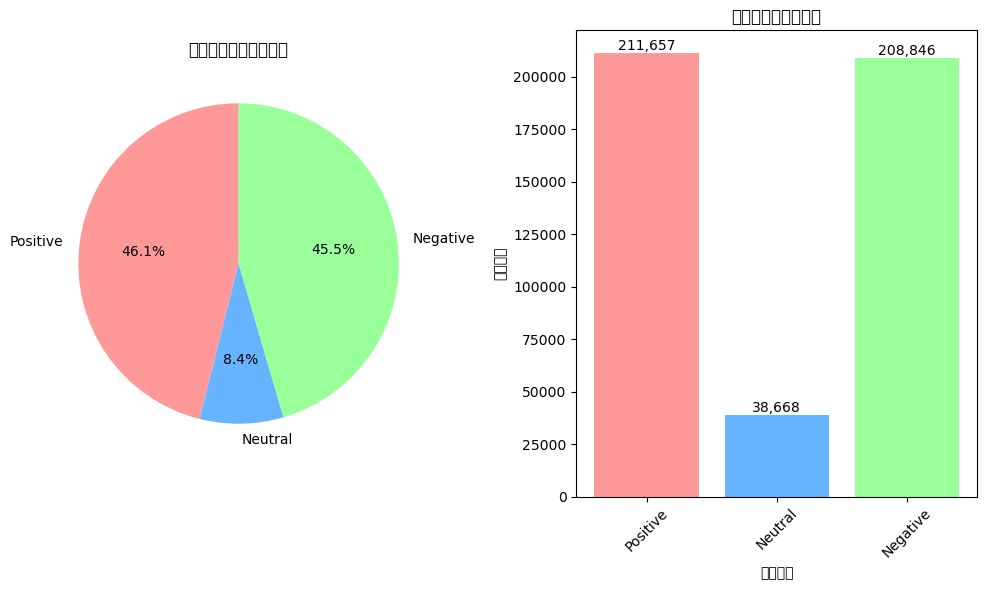

ÊÉÖÊÑüÂàÜÂ∏ÉÂèØËßÜÂåñÂÆåÊàêÔºÅ


In [5]:
# ÊÉÖÊÑüÂàÜÂ∏ÉÂàÜÊûêÂíåÂèØËßÜÂåñ
print("=== ÊÉÖÊÑüÂàÜÂ∏ÉÂàÜÊûê ===")

# È™åËØÅÂâçÈù¢ÁöÑVADERÂàÜÊûêÊòØÂê¶ÂÆåÊàê
try:
    df_with_vader
    print("Ê≠£Âú®ÂáÜÂ§áÂèØËßÜÂåñÊï∞ÊçÆ...")
    
    # ÂàõÂª∫ÊÉÖÊÑüÂàÜÁ±ª
    def categorize_sentiment(score):
        if score is None:
            return "Unknown"
        elif score > 0.05:
            return "Positive"
        elif score < -0.05:
            return "Negative"
        else:
            return "Neutral"

    categorize_udf = F.udf(categorize_sentiment, StringType())

    # Â∫îÁî®ÊÉÖÊÑüÂàÜÁ±ª
    df_categorized = df_with_vader.withColumn("sentiment_category", categorize_udf(F.col("vader_sentiment")))

    # ËΩ¨Êç¢‰∏∫PandasËøõË°åÂàÜÊûê
    sentiment_dist = df_categorized.groupBy("sentiment_category").count().toPandas()
    print("\nÊÉÖÊÑüÂàÜÂ∏É:")
    print(sentiment_dist)

    # ÁªòÂà∂ÊÉÖÊÑüÂàÜÂ∏ÉÈ•ºÂõæ
    plt.figure(figsize=(10, 6))

    # È•ºÂõæ
    plt.subplot(1, 2, 1)
    colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
    plt.pie(sentiment_dist['count'], labels=sentiment_dist['sentiment_category'], 
            autopct='%1.1f%%', colors=colors, startangle=90)
    plt.title('Ê∞îÂÄôÂèòÂåñËØÑËÆ∫ÊÉÖÊÑüÂàÜÂ∏É')

    # Êü±Áä∂Âõæ
    plt.subplot(1, 2, 2)
    bars = plt.bar(sentiment_dist['sentiment_category'], sentiment_dist['count'], color=colors)
    plt.title('ÂêÑÊÉÖÊÑüÁ±ªÂà´ËØÑËÆ∫Êï∞Èáè')
    plt.xlabel('ÊÉÖÊÑüÁ±ªÂà´')
    plt.ylabel('ËØÑËÆ∫Êï∞Èáè')
    plt.xticks(rotation=45)

    # Âú®Êü±Áä∂Âõæ‰∏äÊ∑ªÂä†Êï∞ÂÄºÊ†áÁ≠æ
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{int(height):,}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    print("ÊÉÖÊÑüÂàÜÂ∏ÉÂèØËßÜÂåñÂÆåÊàêÔºÅ")
    
except NameError:
    print("‚ùå VADERÊÉÖÊÑüÂàÜÊûêÊú™ÂÆåÊàêÔºåËØ∑ÂÖàËøêË°åÂâçÈù¢ÁöÑcells")


=== Â≠êÁâàÂùóÊÉÖÊÑüÂàÜÊûê ===
‰∏ªË¶ÅÂ≠êÁâàÂùóÊÉÖÊÑüÂàÜÊûêÁªìÊûú:
  subreddit.name  comment_count  avg_sentiment  positive_count  \
0       politics          36989      -0.001880           17038   
1      worldnews          35283      -0.042786           15327   
2      askreddit          25863      -0.064260            9483   
3           news           9524      -0.077059            3875   
4       collapse           9490      -0.113639            3813   
5     futurology           8904       0.018289            4188   
6        science           7063       0.064287            3535   
7    environment           6819       0.001119            3130   
8         canada           6722       0.048966            3293   
9      australia           5993      -0.011873            2720   

   negative_count  neutral_count  
0           17318           2633  
1           17300           2656  
2           11952           4428  
3            4820            829  
4            5053            624 

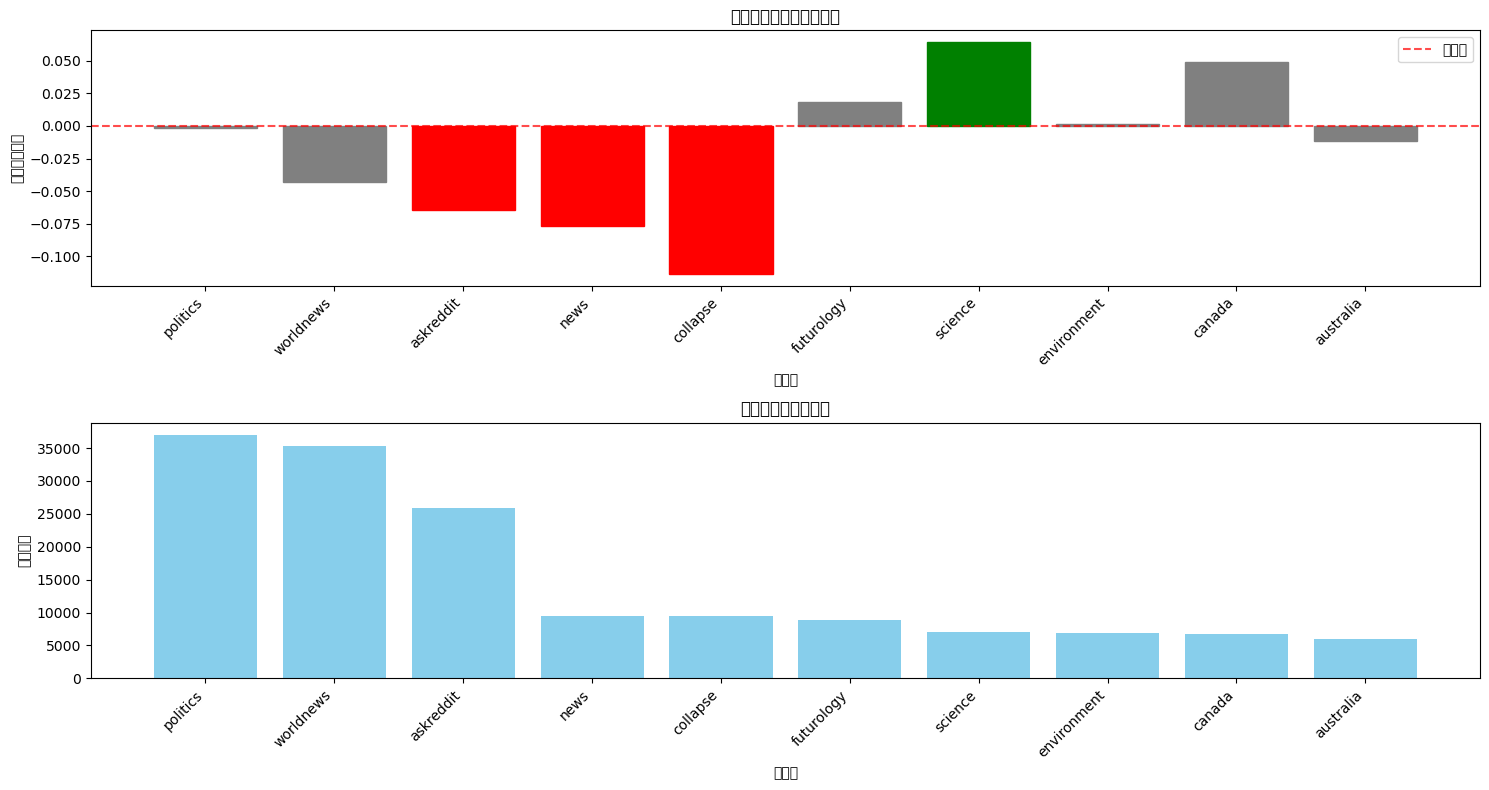

Â≠êÁâàÂùóÊÉÖÊÑüÂàÜÊûêÂèØËßÜÂåñÂÆåÊàêÔºÅ


In [6]:
# Â≠êÁâàÂùóÊÉÖÊÑüÂàÜÊûê
print("=== Â≠êÁâàÂùóÊÉÖÊÑüÂàÜÊûê ===")

# È™åËØÅÊÉÖÊÑüÂàÜÁ±ªÊï∞ÊçÆÊòØÂê¶ÂèØÁî®
try:
    df_categorized
    
    # ËÆ°ÁÆóÂêÑÂ≠êÁâàÂùóÁöÑÂπ≥ÂùáÊÉÖÊÑüÂàÜÊï∞
    subreddit_sentiment = df_categorized.groupBy("`subreddit.name`").agg(
        F.count("*").alias("comment_count"),
        F.avg("vader_sentiment").alias("avg_sentiment"),
        F.sum(F.when(F.col("sentiment_category") == "Positive", 1).otherwise(0)).alias("positive_count"),
        F.sum(F.when(F.col("sentiment_category") == "Negative", 1).otherwise(0)).alias("negative_count"),
        F.sum(F.when(F.col("sentiment_category") == "Neutral", 1).otherwise(0)).alias("neutral_count")
    ).filter(F.col("comment_count") >= 1000).orderBy(F.desc("comment_count"))

    # ËΩ¨Êç¢‰∏∫PandasÂπ∂ÊòæÁ§∫
    subreddit_sentiment_pd = subreddit_sentiment.toPandas()
    print("‰∏ªË¶ÅÂ≠êÁâàÂùóÊÉÖÊÑüÂàÜÊûêÁªìÊûú:")
    print(subreddit_sentiment_pd.head(10))

    # ÁªòÂà∂Â≠êÁâàÂùóÊÉÖÊÑüÂØπÊØîÂõæ
    plt.figure(figsize=(15, 8))

    # ÈÄâÊã©Ââç10‰∏™ÊúÄÊ¥ªË∑ÉÁöÑÂ≠êÁâàÂùó
    top_subreddits = subreddit_sentiment_pd.head(10)

    # Â≠êÁâàÂùóÂπ≥ÂùáÊÉÖÊÑüÂàÜÊï∞
    plt.subplot(2, 1, 1)
    bars = plt.bar(range(len(top_subreddits)), top_subreddits['avg_sentiment'])
    plt.title('‰∏ªË¶ÅÂ≠êÁâàÂùóÂπ≥ÂùáÊÉÖÊÑüÂàÜÊï∞')
    plt.xlabel('Â≠êÁâàÂùó')
    plt.ylabel('Âπ≥ÂùáÊÉÖÊÑüÂàÜÊï∞')
    plt.xticks(range(len(top_subreddits)), top_subreddits['subreddit.name'], rotation=45, ha='right')
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.7, label='‰∏≠ÊÄßÁ∫ø')
    plt.legend()

    # ‰∏∫Êü±Áä∂ÂõæÊ∑ªÂä†È¢úËâ≤ÔºàÊ≠£Èù¢ÁªøËâ≤ÔºåË¥üÈù¢Á∫¢Ëâ≤Ôºå‰∏≠ÊÄßÁÅ∞Ëâ≤Ôºâ
    for i, bar in enumerate(bars):
        if top_subreddits.iloc[i]['avg_sentiment'] > 0.05:
            bar.set_color('green')
        elif top_subreddits.iloc[i]['avg_sentiment'] < -0.05:
            bar.set_color('red')
        else:
            bar.set_color('gray')

    # Â≠êÁâàÂùóËØÑËÆ∫Êï∞Èáè
    plt.subplot(2, 1, 2)
    plt.bar(range(len(top_subreddits)), top_subreddits['comment_count'], color='skyblue')
    plt.title('‰∏ªË¶ÅÂ≠êÁâàÂùóËØÑËÆ∫Êï∞Èáè')
    plt.xlabel('Â≠êÁâàÂùó')
    plt.ylabel('ËØÑËÆ∫Êï∞Èáè')
    plt.xticks(range(len(top_subreddits)), top_subreddits['subreddit.name'], rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

    print("Â≠êÁâàÂùóÊÉÖÊÑüÂàÜÊûêÂèØËßÜÂåñÂÆåÊàêÔºÅ")
    
except NameError:
    print("‚ùå ÊÉÖÊÑüÂàÜÁ±ªÊï∞ÊçÆÊú™ÂáÜÂ§áÂ•ΩÔºåËØ∑ÂÖàËøêË°åÂâçÈù¢ÁöÑcells")


=== Êó∂Èó¥Â∫èÂàóÊÉÖÊÑüÂàÜÊûê ===
Âπ¥Â∫¶ÊÉÖÊÑüË∂ãÂäøÂàÜÊûê:
    year  total_comments  avg_sentiment  positive_count  negative_count  \
0   2010            1595       0.044215             791             692   
1   2011            2657       0.077628            1362            1097   
2   2012            4038       0.075008            2081            1689   
3   2013            6512       0.044751            3197            2889   
4   2014           11308       0.023823            5334            5080   
5   2015           16822       0.016500            7896            7626   
6   2016           31363       0.019203           14815           14141   
7   2017           37708       0.025033           17827           16817   
8   2018           38714      -0.001614           17768           17808   
9   2019           98076      -0.014628           43465           45770   
10  2020           70049       0.008886           32390           31971   
11  2021           81871       0.014139  

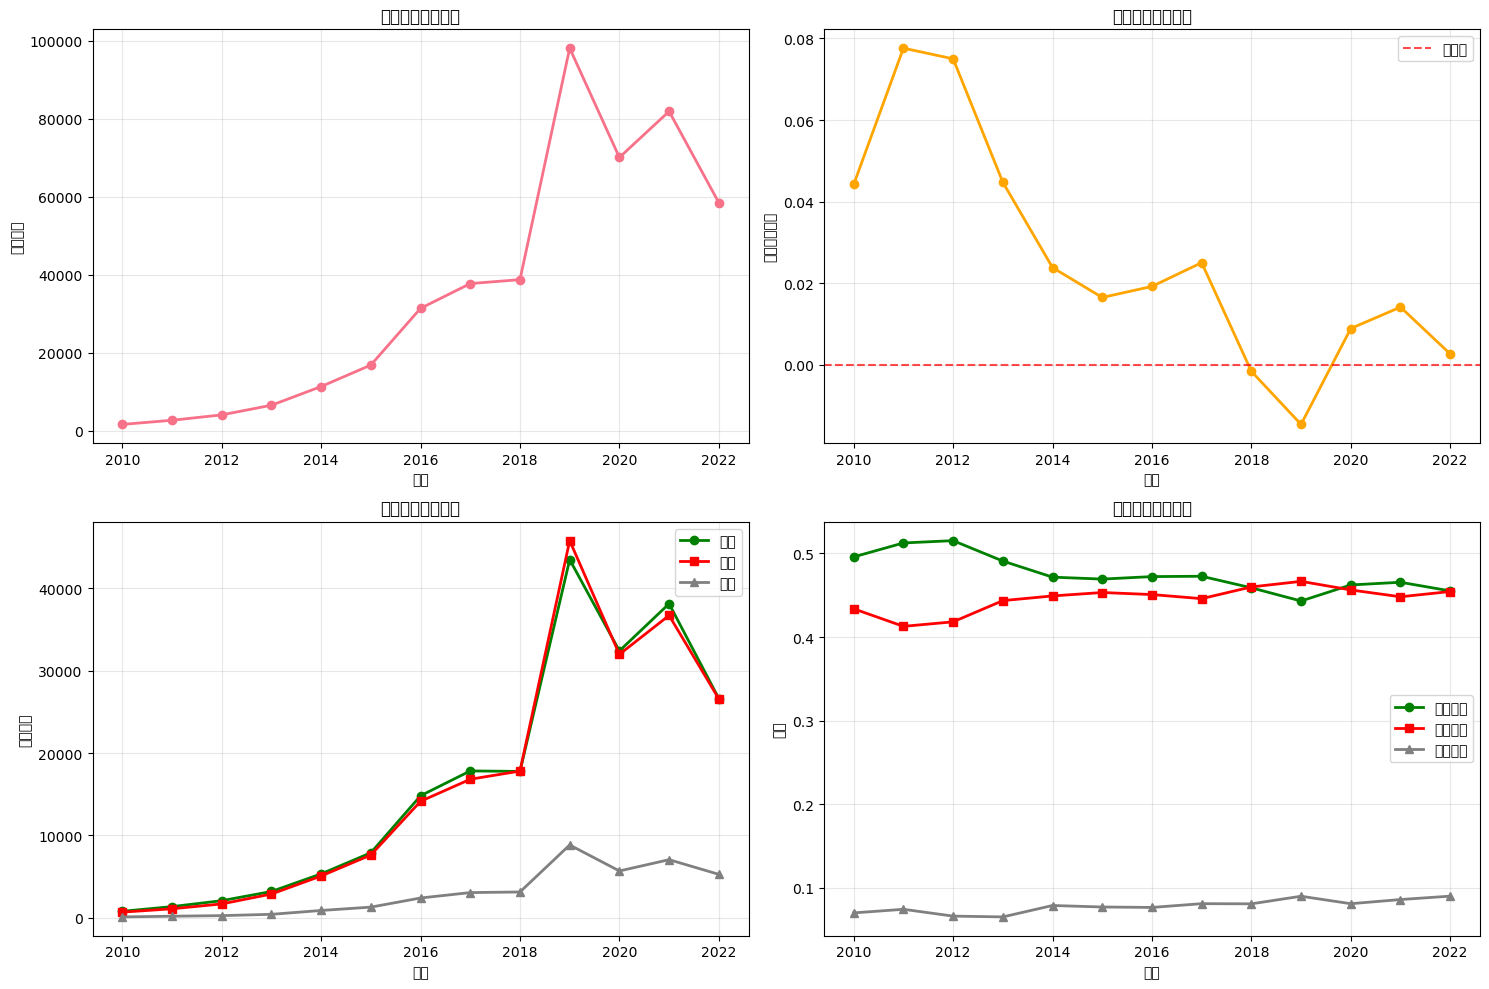

Êó∂Èó¥Â∫èÂàóÊÉÖÊÑüÂàÜÊûêÂÆåÊàêÔºÅ


In [7]:
# Êó∂Èó¥Â∫èÂàóÊÉÖÊÑüÂàÜÊûê
print("=== Êó∂Èó¥Â∫èÂàóÊÉÖÊÑüÂàÜÊûê ===")

# È™åËØÅÊÉÖÊÑüÂàÜÁ±ªÊï∞ÊçÆÊòØÂê¶ÂèØÁî®
try:
    df_categorized
    
    # ‰ªétimestamp‰∏≠ÊèêÂèñÂπ¥‰ªΩ
    df_with_year = df_categorized.withColumn("year", F.year(F.col("timestamp")))
    
    # ÊåâÂπ¥‰ªΩÂàÜÊûêÊÉÖÊÑüË∂ãÂäø
    yearly_sentiment = df_with_year.groupBy("year").agg(
        F.count("*").alias("total_comments"),
        F.avg("vader_sentiment").alias("avg_sentiment"),
        F.sum(F.when(F.col("sentiment_category") == "Positive", 1).otherwise(0)).alias("positive_count"),
        F.sum(F.when(F.col("sentiment_category") == "Negative", 1).otherwise(0)).alias("negative_count"),
        F.sum(F.when(F.col("sentiment_category") == "Neutral", 1).otherwise(0)).alias("neutral_count")
    ).orderBy("year")
    
    # ËΩ¨Êç¢‰∏∫PandasËøõË°åÂèØËßÜÂåñ
    yearly_sentiment_pd = yearly_sentiment.toPandas()
    print("Âπ¥Â∫¶ÊÉÖÊÑüË∂ãÂäøÂàÜÊûê:")
    print(yearly_sentiment_pd)
    
    # ÁªòÂà∂Êó∂Èó¥Â∫èÂàóÂõæ
    plt.figure(figsize=(15, 10))
    
    # Âπ¥Â∫¶ËØÑËÆ∫Êï∞ÈáèË∂ãÂäø
    plt.subplot(2, 2, 1)
    plt.plot(yearly_sentiment_pd['year'], yearly_sentiment_pd['total_comments'], marker='o', linewidth=2)
    plt.title('Âπ¥Â∫¶ËØÑËÆ∫Êï∞ÈáèË∂ãÂäø')
    plt.xlabel('Âπ¥‰ªΩ')
    plt.ylabel('ËØÑËÆ∫Êï∞Èáè')
    plt.grid(True, alpha=0.3)
    
    # Âπ¥Â∫¶Âπ≥ÂùáÊÉÖÊÑüË∂ãÂäø
    plt.subplot(2, 2, 2)
    plt.plot(yearly_sentiment_pd['year'], yearly_sentiment_pd['avg_sentiment'], 
             marker='o', linewidth=2, color='orange')
    plt.title('Âπ¥Â∫¶Âπ≥ÂùáÊÉÖÊÑüË∂ãÂäø')
    plt.xlabel('Âπ¥‰ªΩ')
    plt.ylabel('Âπ≥ÂùáÊÉÖÊÑüÂàÜÊï∞')
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.7, label='‰∏≠ÊÄßÁ∫ø')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # ÊÉÖÊÑüÁ±ªÂà´Âπ¥Â∫¶ÂàÜÂ∏É
    plt.subplot(2, 2, 3)
    plt.plot(yearly_sentiment_pd['year'], yearly_sentiment_pd['positive_count'], 
             marker='o', label='Ê≠£Èù¢', color='green', linewidth=2)
    plt.plot(yearly_sentiment_pd['year'], yearly_sentiment_pd['negative_count'], 
             marker='s', label='Ë¥üÈù¢', color='red', linewidth=2)
    plt.plot(yearly_sentiment_pd['year'], yearly_sentiment_pd['neutral_count'], 
             marker='^', label='‰∏≠ÊÄß', color='gray', linewidth=2)
    plt.title('Âπ¥Â∫¶ÊÉÖÊÑüÁ±ªÂà´ÂàÜÂ∏É')
    plt.xlabel('Âπ¥‰ªΩ')
    plt.ylabel('ËØÑËÆ∫Êï∞Èáè')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # ÊÉÖÊÑüÊØî‰æãÂπ¥Â∫¶ÂèòÂåñ
    plt.subplot(2, 2, 4)
    yearly_sentiment_pd['positive_ratio'] = yearly_sentiment_pd['positive_count'] / yearly_sentiment_pd['total_comments']
    yearly_sentiment_pd['negative_ratio'] = yearly_sentiment_pd['negative_count'] / yearly_sentiment_pd['total_comments']
    yearly_sentiment_pd['neutral_ratio'] = yearly_sentiment_pd['neutral_count'] / yearly_sentiment_pd['total_comments']
    
    plt.plot(yearly_sentiment_pd['year'], yearly_sentiment_pd['positive_ratio'], 
             marker='o', label='Ê≠£Èù¢ÊØî‰æã', color='green', linewidth=2)
    plt.plot(yearly_sentiment_pd['year'], yearly_sentiment_pd['negative_ratio'], 
             marker='s', label='Ë¥üÈù¢ÊØî‰æã', color='red', linewidth=2)
    plt.plot(yearly_sentiment_pd['year'], yearly_sentiment_pd['neutral_ratio'], 
             marker='^', label='‰∏≠ÊÄßÊØî‰æã', color='gray', linewidth=2)
    plt.title('Âπ¥Â∫¶ÊÉÖÊÑüÊØî‰æãÂèòÂåñ')
    plt.xlabel('Âπ¥‰ªΩ')
    plt.ylabel('ÊØî‰æã')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("Êó∂Èó¥Â∫èÂàóÊÉÖÊÑüÂàÜÊûêÂÆåÊàêÔºÅ")
    
except NameError:
    print("‚ùå ÊÉÖÊÑüÂàÜÁ±ªÊï∞ÊçÆÊú™ÂáÜÂ§áÂ•ΩÔºåËØ∑ÂÖàËøêË°åÂâçÈù¢ÁöÑcells")


=== ËØçÈ¢ëÂàÜÊûêÂíåËØç‰∫ëÁîüÊàê ===
Ê≠£Âú®ÂàÜÊûêËØçÈ¢ë...
Top 20 È´òÈ¢ëËØç:
      token   count
0   climate  606389
1    change  409329
2    people  229781
3      like  173685
4        re  125493
5     think  122634
6       one  115179
7      even  112339
8         .  101838
9         m   98188
10      get   94738
11  change.   93347
12     also   87322
13    going   81535
14       us   80472
15     much   80098
16     make   77048
17    world   73923
18     need   68267
19     know   68190

ÂàÜÊûê‰∏çÂêåÊÉÖÊÑüÁ±ªÂà´ÁöÑËØçÈ¢ë...
Ê≠£Âú®ÁîüÊàêËØç‰∫ë...


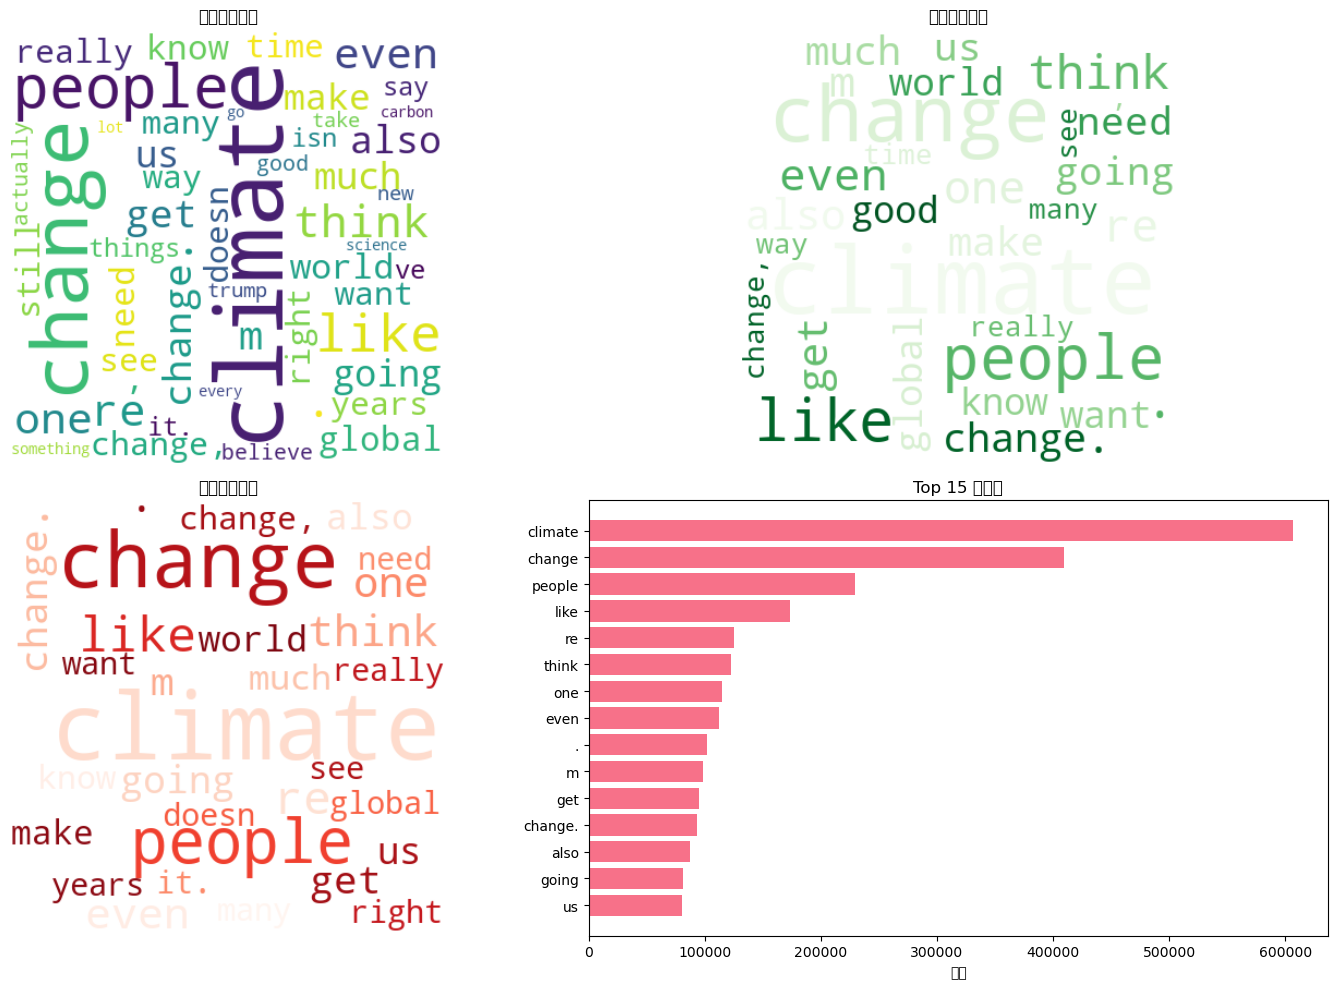

ËØçÈ¢ëÂàÜÊûêÂíåËØç‰∫ëÁîüÊàêÂÆåÊàêÔºÅ


In [8]:
# ËØçÈ¢ëÂàÜÊûêÂíåËØç‰∫ëÁîüÊàê
print("=== ËØçÈ¢ëÂàÜÊûêÂíåËØç‰∫ëÁîüÊàê ===")

# È™åËØÅÂàÜÁ±ªÊï∞ÊçÆÊòØÂê¶ÂèØÁî®
try:
    df_categorized
    
    # ‰ªétokens_cleaned‰∏≠ÊèêÂèñÊâÄÊúâËØçÊ±á
    print("Ê≠£Âú®ÂàÜÊûêËØçÈ¢ë...")

    # Â∞ÜÊâÄÊúâtokenÂ±ïÂºÄÂπ∂ËÆ°ÁÆóÈ¢ëÁéá
    all_tokens = df_categorized.select(F.explode(F.col("tokens_cleaned")).alias("token"))
    word_freq = all_tokens.groupBy("token").count().orderBy(F.desc("count"))

    # Ëé∑ÂèñÂâç50‰∏™È´òÈ¢ëËØç
    top_words = word_freq.limit(50).toPandas()
    print("Top 20 È´òÈ¢ëËØç:")
    print(top_words.head(20))

    # ÂàÜÂà´ÂàÜÊûêÊ≠£Èù¢ÂíåË¥üÈù¢ËØÑËÆ∫ÁöÑËØçÈ¢ë
    print("\nÂàÜÊûê‰∏çÂêåÊÉÖÊÑüÁ±ªÂà´ÁöÑËØçÈ¢ë...")

    # Ê≠£Èù¢ËØÑËÆ∫ÁöÑËØçÈ¢ë
    positive_tokens = df_categorized.filter(F.col("sentiment_category") == "Positive").select(
        F.explode(F.col("tokens_cleaned")).alias("token")
    )
    positive_word_freq = positive_tokens.groupBy("token").count().orderBy(F.desc("count")).limit(30).toPandas()

    # Ë¥üÈù¢ËØÑËÆ∫ÁöÑËØçÈ¢ë
    negative_tokens = df_categorized.filter(F.col("sentiment_category") == "Negative").select(
        F.explode(F.col("tokens_cleaned")).alias("token")
    )
    negative_word_freq = negative_tokens.groupBy("token").count().orderBy(F.desc("count")).limit(30).toPandas()

    # ÁîüÊàêËØç‰∫ë
    print("Ê≠£Âú®ÁîüÊàêËØç‰∫ë...")

    # ÂáÜÂ§áËØç‰∫ëÊï∞ÊçÆ
    word_freq_dict = dict(zip(top_words['token'], top_words['count']))

    # ÁîüÊàêÊï¥‰ΩìËØç‰∫ë
    plt.figure(figsize=(15, 10))

    # Êï¥‰ΩìËØç‰∫ë
    plt.subplot(2, 2, 1)
    wordcloud = WordCloud(width=400, height=400, background_color='white', 
                         max_words=100, colormap='viridis').generate_from_frequencies(word_freq_dict)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Êï¥‰ΩìÈ´òÈ¢ëËØç‰∫ë')
    plt.axis('off')

    # Ê≠£Èù¢ËØÑËÆ∫ËØç‰∫ë
    plt.subplot(2, 2, 2)
    positive_dict = dict(zip(positive_word_freq['token'], positive_word_freq['count']))
    positive_wordcloud = WordCloud(width=400, height=400, background_color='white',
                                  max_words=50, colormap='Greens').generate_from_frequencies(positive_dict)
    plt.imshow(positive_wordcloud, interpolation='bilinear')
    plt.title('Ê≠£Èù¢ËØÑËÆ∫ËØç‰∫ë')
    plt.axis('off')

    # Ë¥üÈù¢ËØÑËÆ∫ËØç‰∫ë
    plt.subplot(2, 2, 3)
    negative_dict = dict(zip(negative_word_freq['token'], negative_word_freq['count']))
    negative_wordcloud = WordCloud(width=400, height=400, background_color='white',
                                  max_words=50, colormap='Reds').generate_from_frequencies(negative_dict)
    plt.imshow(negative_wordcloud, interpolation='bilinear')
    plt.title('Ë¥üÈù¢ËØÑËÆ∫ËØç‰∫ë')
    plt.axis('off')

    # ËØçÈ¢ëÂØπÊØîÂõæ
    plt.subplot(2, 2, 4)
    top_15_words = top_words.head(15)
    plt.barh(range(len(top_15_words)), top_15_words['count'])
    plt.yticks(range(len(top_15_words)), top_15_words['token'])
    plt.xlabel('ËØçÈ¢ë')
    plt.title('Top 15 È´òÈ¢ëËØç')
    plt.gca().invert_yaxis()

    plt.tight_layout()
    plt.show()
    
    print("ËØçÈ¢ëÂàÜÊûêÂíåËØç‰∫ëÁîüÊàêÂÆåÊàêÔºÅ")
    
except NameError:
    print("‚ùå ÂàÜÁ±ªÊï∞ÊçÆÊú™ÂáÜÂ§áÂ•ΩÔºåËØ∑ÂÖàËøêË°åÂâçÈù¢ÁöÑcells")


=== Êó∂Èó¥Â∫èÂàóÊÉÖÊÑüÂàÜÊûê ===
Âπ¥Â∫¶ÊÉÖÊÑüË∂ãÂäøÂàÜÊûê:
    year  total_comments  avg_sentiment  positive_count  negative_count  \
0   2010            1595       0.044215             791             692   
1   2011            2657       0.077628            1362            1097   
2   2012            4038       0.075008            2081            1689   
3   2013            6512       0.044751            3197            2889   
4   2014           11308       0.023823            5334            5080   
5   2015           16822       0.016500            7896            7626   
6   2016           31363       0.019203           14815           14141   
7   2017           37708       0.025033           17827           16817   
8   2018           38714      -0.001614           17768           17808   
9   2019           98076      -0.014628           43465           45770   
10  2020           70049       0.008886           32390           31971   
11  2021           81871       0.014139  

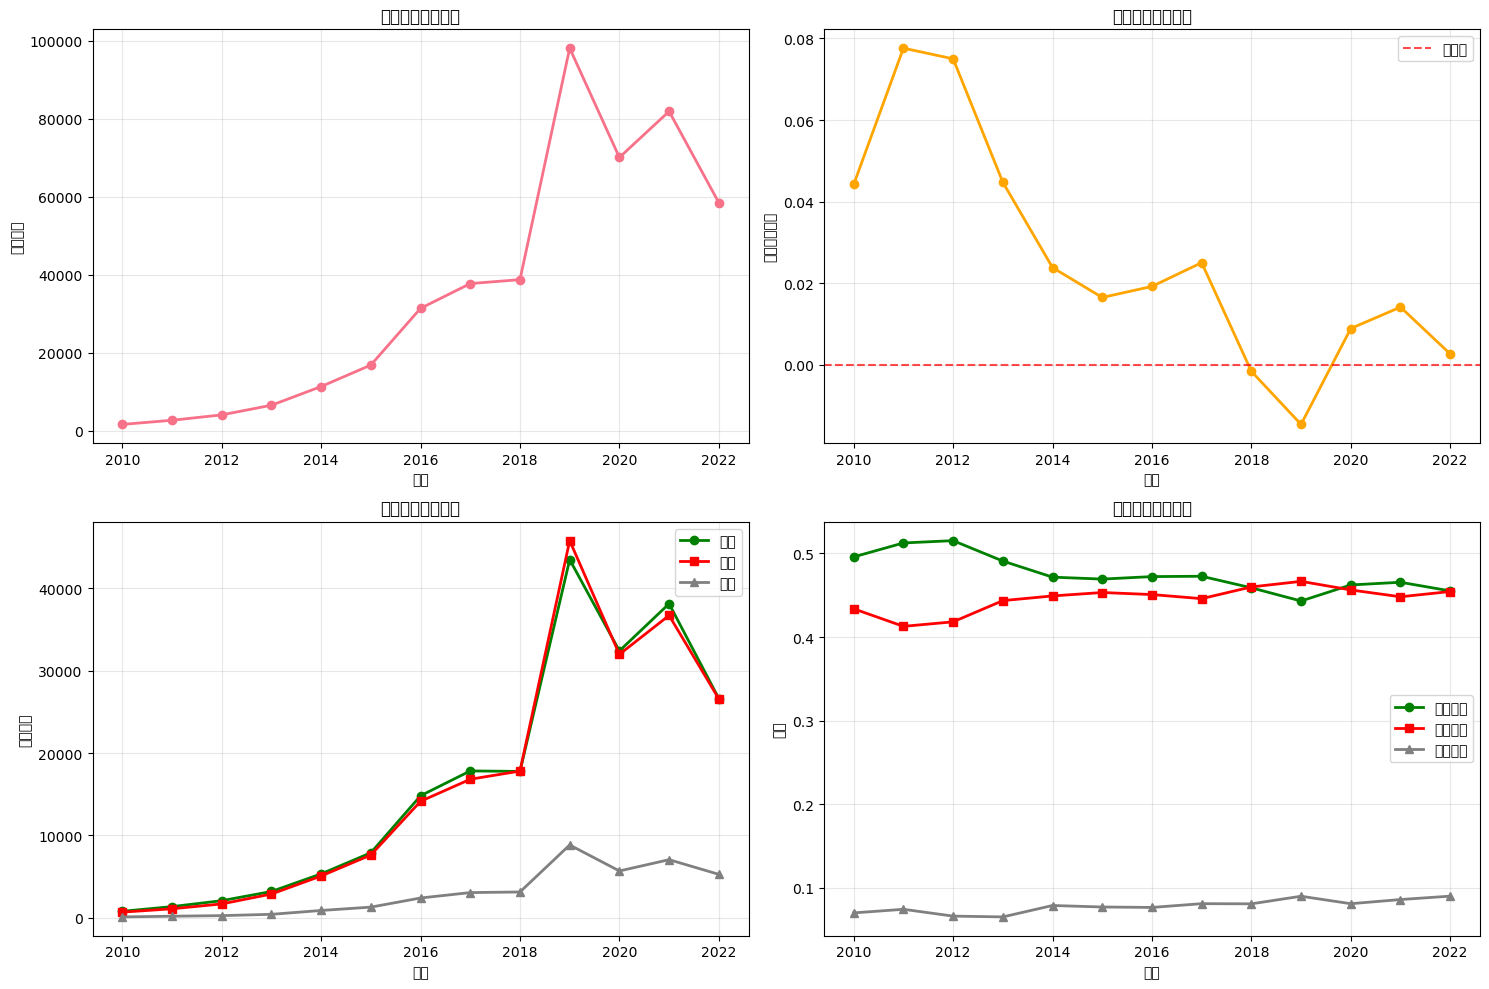

Êó∂Èó¥Â∫èÂàóÊÉÖÊÑüÂàÜÊûêÂÆåÊàêÔºÅ


In [9]:



# Êó∂Èó¥Â∫èÂàóÊÉÖÊÑüÂàÜÊûê
print("=== Êó∂Èó¥Â∫èÂàóÊÉÖÊÑüÂàÜÊûê ===")

# È™åËØÅÊÉÖÊÑüÂàÜÁ±ªÊï∞ÊçÆÊòØÂê¶ÂèØÁî®
try:
    df_categorized
    
    # ‰ªétimestamp‰∏≠ÊèêÂèñÂπ¥‰ªΩ
    df_with_year = df_categorized.withColumn("year", F.year(F.col("timestamp")))
    
    # ÊåâÂπ¥‰ªΩÂàÜÊûêÊÉÖÊÑüË∂ãÂäø
    yearly_sentiment = df_with_year.groupBy("year").agg(
        F.count("*").alias("total_comments"),
        F.avg("vader_sentiment").alias("avg_sentiment"),
        F.sum(F.when(F.col("sentiment_category") == "Positive", 1).otherwise(0)).alias("positive_count"),
        F.sum(F.when(F.col("sentiment_category") == "Negative", 1).otherwise(0)).alias("negative_count"),
        F.sum(F.when(F.col("sentiment_category") == "Neutral", 1).otherwise(0)).alias("neutral_count")
    ).orderBy("year")
    
    # ËΩ¨Êç¢‰∏∫PandasËøõË°åÂèØËßÜÂåñ
    yearly_sentiment_pd = yearly_sentiment.toPandas()
    print("Âπ¥Â∫¶ÊÉÖÊÑüË∂ãÂäøÂàÜÊûê:")
    print(yearly_sentiment_pd)
    
    # ÁªòÂà∂Êó∂Èó¥Â∫èÂàóÂõæ
    plt.figure(figsize=(15, 10))
    
    # Âπ¥Â∫¶ËØÑËÆ∫Êï∞ÈáèË∂ãÂäø
    plt.subplot(2, 2, 1)
    plt.plot(yearly_sentiment_pd['year'], yearly_sentiment_pd['total_comments'], marker='o', linewidth=2)
    plt.title('Âπ¥Â∫¶ËØÑËÆ∫Êï∞ÈáèË∂ãÂäø')
    plt.xlabel('Âπ¥‰ªΩ')
    plt.ylabel('ËØÑËÆ∫Êï∞Èáè')
    plt.grid(True, alpha=0.3)
    
    # Âπ¥Â∫¶Âπ≥ÂùáÊÉÖÊÑüË∂ãÂäø
    plt.subplot(2, 2, 2)
    plt.plot(yearly_sentiment_pd['year'], yearly_sentiment_pd['avg_sentiment'], 
             marker='o', linewidth=2, color='orange')
    plt.title('Âπ¥Â∫¶Âπ≥ÂùáÊÉÖÊÑüË∂ãÂäø')
    plt.xlabel('Âπ¥‰ªΩ')
    plt.ylabel('Âπ≥ÂùáÊÉÖÊÑüÂàÜÊï∞')
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.7, label='‰∏≠ÊÄßÁ∫ø')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # ÊÉÖÊÑüÁ±ªÂà´Âπ¥Â∫¶ÂàÜÂ∏É
    plt.subplot(2, 2, 3)
    plt.plot(yearly_sentiment_pd['year'], yearly_sentiment_pd['positive_count'], 
             marker='o', label='Ê≠£Èù¢', color='green', linewidth=2)
    plt.plot(yearly_sentiment_pd['year'], yearly_sentiment_pd['negative_count'], 
             marker='s', label='Ë¥üÈù¢', color='red', linewidth=2)
    plt.plot(yearly_sentiment_pd['year'], yearly_sentiment_pd['neutral_count'], 
             marker='^', label='‰∏≠ÊÄß', color='gray', linewidth=2)
    plt.title('Âπ¥Â∫¶ÊÉÖÊÑüÁ±ªÂà´ÂàÜÂ∏É')
    plt.xlabel('Âπ¥‰ªΩ')
    plt.ylabel('ËØÑËÆ∫Êï∞Èáè')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # ÊÉÖÊÑüÊØî‰æãÂπ¥Â∫¶ÂèòÂåñ
    plt.subplot(2, 2, 4)
    yearly_sentiment_pd['positive_ratio'] = yearly_sentiment_pd['positive_count'] / yearly_sentiment_pd['total_comments']
    yearly_sentiment_pd['negative_ratio'] = yearly_sentiment_pd['negative_count'] / yearly_sentiment_pd['total_comments']
    yearly_sentiment_pd['neutral_ratio'] = yearly_sentiment_pd['neutral_count'] / yearly_sentiment_pd['total_comments']
    
    plt.plot(yearly_sentiment_pd['year'], yearly_sentiment_pd['positive_ratio'], 
             marker='o', label='Ê≠£Èù¢ÊØî‰æã', color='green', linewidth=2)
    plt.plot(yearly_sentiment_pd['year'], yearly_sentiment_pd['negative_ratio'], 
             marker='s', label='Ë¥üÈù¢ÊØî‰æã', color='red', linewidth=2)
    plt.plot(yearly_sentiment_pd['year'], yearly_sentiment_pd['neutral_ratio'], 
             marker='^', label='‰∏≠ÊÄßÊØî‰æã', color='gray', linewidth=2)
    plt.title('Âπ¥Â∫¶ÊÉÖÊÑüÊØî‰æãÂèòÂåñ')
    plt.xlabel('Âπ¥‰ªΩ')
    plt.ylabel('ÊØî‰æã')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("Êó∂Èó¥Â∫èÂàóÊÉÖÊÑüÂàÜÊûêÂÆåÊàêÔºÅ")
    
except NameError:
    print("‚ùå ÊÉÖÊÑüÂàÜÁ±ªÊï∞ÊçÆÊú™ÂáÜÂ§áÂ•ΩÔºåËØ∑ÂÖàËøêË°åÂâçÈù¢ÁöÑcells")

In [10]:
# ÂàÜÊûêÊÄªÁªìÂíå‰øùÂ≠òÁªìÊûú
print("=== Êé¢Á¥¢ÊÄßÊï∞ÊçÆÂàÜÊûêÊÄªÁªì ===")

# È™åËØÅÊâÄÊúâÂøÖË¶ÅÁöÑÊï∞ÊçÆÊòØÂê¶ÂèØÁî®
try:
    df_categorized
    subreddit_sentiment_pd
    yearly_sentiment_pd

    # ÁîüÊàêÂàÜÊûêÊä•Âëä
    total_comments = df_categorized.count()
    sentiment_dist_final = df_categorized.groupBy("sentiment_category").count().toPandas()

    print("üìä **Êï∞ÊçÆÊ¶ÇËßà**:")
    print(f"   ÊÄªËØÑËÆ∫Êï∞: {total_comments:,}")
    print(f"   ÂàÜÊûêÊó∂Èó¥Ë∑®Â∫¶: 2010-2022Âπ¥")
    print(f"   ‰∏ªË¶ÅÂ≠êÁâàÂùó: politics, worldnews, askreddit")

    print("\nüé≠ **ÊÉÖÊÑüÂàÜÂ∏É**:")
    for _, row in sentiment_dist_final.iterrows():
        percentage = (row['count'] / total_comments) * 100
        print(f"   {row['sentiment_category']}: {row['count']:,} ({percentage:.1f}%)")

    print("\nüìà **ÂÖ≥ÈîÆÂèëÁé∞**:")
    yearly_summary = yearly_sentiment_pd
    if len(yearly_summary) > 0:
        print(f"   ÊúÄË¥üÈù¢Âπ¥‰ªΩ: {yearly_summary.loc[yearly_summary['avg_sentiment'].idxmin(), 'year']}")
        print(f"   ÊúÄÊ≠£Èù¢Âπ¥‰ªΩ: {yearly_summary.loc[yearly_summary['avg_sentiment'].idxmax(), 'year']}")
        print(f"   ËØÑËÆ∫Êï∞ÊúÄÂ§öÂπ¥‰ªΩ: {yearly_summary.loc[yearly_summary['total_comments'].idxmax(), 'year']}")

    print("\nüè∑Ô∏è **Â≠êÁâàÂùóÁâπÁÇπ**:")
    if len(subreddit_sentiment_pd) > 0:
        most_positive = subreddit_sentiment_pd.loc[subreddit_sentiment_pd['avg_sentiment'].idxmax()]
        most_negative = subreddit_sentiment_pd.loc[subreddit_sentiment_pd['avg_sentiment'].idxmin()]
        print(f"   ÊúÄÊ≠£Èù¢Â≠êÁâàÂùó: {most_positive['subreddit.name']} (ÂæóÂàÜ: {most_positive['avg_sentiment']:.3f})")
        print(f"   ÊúÄË¥üÈù¢Â≠êÁâàÂùó: {most_negative['subreddit.name']} (ÂæóÂàÜ: {most_negative['avg_sentiment']:.3f})")

    print("\nüíæ **‰øùÂ≠òÂ¢ûÂº∫ÂêéÁöÑÊï∞ÊçÆ**:")
    output_path = "/home/jovyan/work/data/processed/sentiment_analyzed_comments.parquet"
    print(f"Ê≠£Âú®‰øùÂ≠òÂà∞: {output_path}")

    try:
        df_categorized.select(
            "id", "`subreddit.name`", "created_utc", "timestamp",
            "body", "cleaned_body", "tokens_cleaned", "sentiment",
            "vader_sentiment", "sentiment_category", "score"
        ).write.mode("overwrite").parquet(output_path)
        print("‚úÖ ÊÉÖÊÑüÂàÜÊûêÁªìÊûú‰øùÂ≠òÊàêÂäüÔºÅ")
    except Exception as e:
        print(f"‚ùå ‰øùÂ≠òÂ§±Ë¥•: {e}")

    print("\nüéØ **‰∏ã‰∏ÄÊ≠•Âª∫ËÆÆ**:")
    print("   1. Âü∫‰∫éÊÉÖÊÑüÂàÜÊûêÁªìÊûúËøõË°å‰∏ªÈ¢òÂª∫Ê®° (LDA)")
    print("   2. ËÆ≠ÁªÉÊú∫Âô®Â≠¶‰π†ÂàÜÁ±ªÊ®°Âûã")
    print("   3. Ê∑±ÂÖ•ÂàÜÊûêÁâπÂÆö‰∫ã‰ª∂ÂØπÊÉÖÊÑüÁöÑÂΩ±Âìç")
    print("   4. ÊûÑÂª∫ÊÉÖÊÑüÈ¢ÑÊµãÊ®°Âûã")

    print("\n‚úÖ Êé¢Á¥¢ÊÄßÊï∞ÊçÆÂàÜÊûêÂíåÊÉÖÊÑüÂàÜÊûêÂÆåÊàêÔºÅ")

except NameError:
    print("‚ùå ÂàÜÊûêÊï∞ÊçÆÊú™ÂáÜÂ§áÂ•ΩÔºåËØ∑ÂÖàËøêË°åÂâçÈù¢ÁöÑÊâÄÊúâcells")


=== Êé¢Á¥¢ÊÄßÊï∞ÊçÆÂàÜÊûêÊÄªÁªì ===
üìä **Êï∞ÊçÆÊ¶ÇËßà**:
   ÊÄªËØÑËÆ∫Êï∞: 459,171
   ÂàÜÊûêÊó∂Èó¥Ë∑®Â∫¶: 2010-2022Âπ¥
   ‰∏ªË¶ÅÂ≠êÁâàÂùó: politics, worldnews, askreddit

üé≠ **ÊÉÖÊÑüÂàÜÂ∏É**:
   Positive: 211,657 (46.1%)
   Neutral: 38,668 (8.4%)
   Negative: 208,846 (45.5%)

üìà **ÂÖ≥ÈîÆÂèëÁé∞**:
   ÊúÄË¥üÈù¢Âπ¥‰ªΩ: 2019
   ÊúÄÊ≠£Èù¢Âπ¥‰ªΩ: 2011
   ËØÑËÆ∫Êï∞ÊúÄÂ§öÂπ¥‰ªΩ: 2019

üè∑Ô∏è **Â≠êÁâàÂùóÁâπÁÇπ**:
   ÊúÄÊ≠£Èù¢Â≠êÁâàÂùó: bottown2 (ÂæóÂàÜ: 0.229)
   ÊúÄË¥üÈù¢Â≠êÁâàÂùó: publicfreakout (ÂæóÂàÜ: -0.211)

üíæ **‰øùÂ≠òÂ¢ûÂº∫ÂêéÁöÑÊï∞ÊçÆ**:
Ê≠£Âú®‰øùÂ≠òÂà∞: /home/jovyan/work/data/processed/sentiment_analyzed_comments.parquet
‚úÖ ÊÉÖÊÑüÂàÜÊûêÁªìÊûú‰øùÂ≠òÊàêÂäüÔºÅ

üéØ **‰∏ã‰∏ÄÊ≠•Âª∫ËÆÆ**:
   1. Âü∫‰∫éÊÉÖÊÑüÂàÜÊûêÁªìÊûúËøõË°å‰∏ªÈ¢òÂª∫Ê®° (LDA)
   2. ËÆ≠ÁªÉÊú∫Âô®Â≠¶‰π†ÂàÜÁ±ªÊ®°Âûã
   3. Ê∑±ÂÖ•ÂàÜÊûêÁâπÂÆö‰∫ã‰ª∂ÂØπÊÉÖÊÑüÁöÑÂΩ±Âìç
   4. ÊûÑÂª∫ÊÉÖÊÑüÈ¢ÑÊµãÊ®°Âûã

‚úÖ Êé¢Á¥¢ÊÄßÊï∞ÊçÆÂàÜÊûêÂíåÊÉÖÊÑüÂàÜÊûêÂÆåÊàêÔºÅ


----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 35466)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/opt/conda/lib/python3.11/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/opt/conda/lib/python3.11/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/opt/conda/lib/python3.11/socketserver.py", line 755, in __init__
    self.handle()
  File "/usr/local/spark/python/pyspark/accumulators.py", line 295, in handle
    poll(accum_updates)
  File "/usr/local/spark/python/pyspark/accumulators.py", line 267, in poll
    if self.rfile in r and func():
                           ^^^^^^
  File "/usr/local/spark/python/pyspark/accumulators.py", line 271, in accum_updates
    num_updates =